Dataset link: https://www.kaggle.com/datasets/csmalarkodi/isot-fake-news-dataset

# **IT 599 GRADUATE CAPSTONE PROJECT**

# **PROJECT TITLE:**
# **Balancing Accuracy, Efficiency, and Fairness in Fake News Detection: A Comparative Study of Machine Learning and Transformer Models**

## RESEARCH QUESTION

 Can DistilBERT achieve >95% of BERT's F1-score with <70% of BERT's training time, while maintaining fairness across politically charged content (no significant difference in false positive rates between left- and right-leaning headlines)?

**Yes** — DistilBERT achieves 99.66% F1 (99.9% of BERT) with 57.7% less training time and no detectable political bias (FPR = 0% for both ideologies).


## **PROJECT OVERVIEW**

 This capstone project presents a reproducible, multi-faceted comparative study of machine learning and deep learning models for binary fake news detection.

 The goal is to balance three critical dimensions in AI-based misinformation detection:
- 1. Accuracy (performance)
- 2. Efficiency (training/inference time, resource usage)
- 3. Ethics (fairness, bias, interpretability)

### The study evaluates six models:
- Traditional ML: Logistic Regression, SVM, Naive Bayes, Random Forest
- Transformer-based: BERT, DistilBERT

## **Project Structure**
## **1. Installation and Setup**

Installs dependencies on natural language processing and machine learning. Loads all the libraries needed to process data, train a model, evaluate the model, and visualize the results.

In [1]:
# Install required packages
!pip install nltk==3.6.7
import nltk
nltk.download("punkt")        # Tokenizer
nltk.download("stopwords")    # Stopwords
nltk.download("wordnet")      # Lemmatizer
nltk.download("omw-1.4")      # Multilingual WordNet

!pip install newspaper3k
!pip install lxml_html_clean
!pip install lime

# Import necessary libraries
import os
import re
import time
import joblib
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, classification_report
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DistilBertTokenizer, DistilBertForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)
from datasets import Dataset
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from lime.lime_text import LimeTextExplainer
import warnings
import logging

### **2. Configuration**
Establishes experimental framework and output directory hierarchy with metrics of reproducibility. Sets logging and environment to achieve consistency in the result of more than one run.

In [2]:
# Set random seeds for reproducibility across multiple runs
SEEDS = [42, 123, 456]
N_RUNS = len(SEEDS)

# Create directory structure for storing results, models, and visualizations
os.makedirs('results', exist_ok=True)
os.makedirs('results/models', exist_ok=True)
os.makedirs('results/plots', exist_ok=True)

# Log environment
logger.info(f"PyTorch version: {torch.__version__}")
logger.info(f"CUDA available: {torch.cuda.is_available()}")

### **3. DataLoader Class**
Is responsible of loading and preprocessing the ISOT Fake News Dataset. Performs text cleaning, tokenization and lemmatization to generate quality input features both using traditional and transformer-based models.



**Dataset:** A uniform subsample (4,000 articles: 2,000 real, 2,000 fake) of the ISOT Fake News Dataset (Zhang, 2018) to guarantee the quality of journalistic text and stylistic variation.

In [3]:
class DataLoader:
    """
    Handles data loading and preprocessing of the ISOT Fake News Dataset (Zhang, 2018)
    - Loads a balanced subset (4,000 articles: 2,000 real, 2,000 fake)
    - Combines and shuffles the datasets to ensure randomness
    - Preprocesses text through cleaning, tokenization, and lemmatization
    - Ensures high-quality journalistic text and stylistic diversity
    """

    def __init__(self, seed=42):
        # Initialize text processing tools
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        self.seed = seed
        np.random.seed(seed)
        torch.manual_seed(seed)

    def _preprocess_text(self, text):
        """
        Preprocess individual text samples from the ISOT dataset:
        1. Convert to lowercase for consistency
        2. Remove URLs, mentions, and hashtags to clean journalistic text
        3. Remove punctuation while preserving word boundaries
        4. Tokenize and remove stopwords to focus on meaningful content
        5. Lemmatize tokens to reduce inflectional forms
        6. Limit to 512 characters to match transformer model constraints
        """
        try:
            text = str(text).lower()
            text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
            text = re.sub(r'\@\w+|\#\w+', '', text)
            text = re.sub(r'[^\w\s]', '', text)
            tokens = word_tokenize(text)
            tokens = [t for t in tokens if t not in self.stop_words and len(t) > 2 and t.isalpha()]
            return ' '.join([self.lemmatizer.lemmatize(t) for t in tokens])[:512]
        except Exception as e:
            logger.error(f"Preprocessing error: {str(e)}")
            return ""

    def load_data(self):
        """
        Load and prepare the ISOT Fake News Dataset:
        1. Load 2,000 real and 2,000 fake news articles from CSV files
        2. Combine and shuffle to ensure balanced representation
        3. Preprocess text using advanced NLP techniques
        4. Remove duplicates to prevent data leakage
        5. Validate class distribution for balanced evaluation
        """
        try:
            # Load balanced subsets from the ISOT dataset
            real_df = pd.read_csv("True.csv").sample(2000, random_state=self.seed)
            fake_df = pd.read_csv("Fake.csv").sample(2000, random_state=self.seed)
            real_df['label'] = 0
            fake_df['label'] = 1

            # Combine and shuffle for randomized training
            df = pd.concat([real_df, fake_df], ignore_index=True).sample(frac=1, random_state=self.seed)

            # Combine title and text to create comprehensive input features
            df['text'] = (df['title'].fillna('') + " " + df['text'].fillna(''))
            df['text'] = df['text'].apply(self._preprocess_text)
            df = df[['text', 'label']].dropna().reset_index(drop=True)
            df = df[df['text'].str.len() > 10]  # Remove empty or very short texts

            # Remove duplicates after preprocessing to ensure data quality
            initial_len = len(df)
            df = df.drop_duplicates(subset=['text']).reset_index(drop=True)
            final_len = len(df)
            logger.info(f"Removed {initial_len - final_len} duplicate texts after preprocessing.")

            # Validate class distribution maintains balance
            dist = df['label'].value_counts(normalize=True)
            print(f"\nClass distribution after preprocessing (seed={self.seed}):")
            print(dist)
            return df
        except Exception as e:
            logger.error(f"Data load error: {str(e)}")
            return None

### **4. FeatureExtractor Class**

Breaks down normal text into number systems that can be used by various algorithms. Supports both classic TF-IDF features as well as transformer model tokenization.




In [4]:
class FeatureExtractor:
    """
    Handles feature extraction for both traditional ML models and transformer models
    Converts raw text into numerical representations suitable for different algorithms
    """

    def __init__(self):
        # Initialize feature extractors with optimized parameters
        self.tfidf = TfidfVectorizer(
            ngram_range=(1, 2),          # Capture unigrams and bigrams
            stop_words='english',        # Remove common English stopwords
            min_df=5,                    # Ignore terms that appear in fewer than 5 documents
            max_df=0.7,                  # Ignore terms that appear in more than 70% of documents
            max_features=5000            # Limit vocabulary to top 5000 features
        )
        # Initialize tokenizers for transformer models
        self.bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        self.distilbert_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

    def extract_traditional_features(self, texts, fit=False):
        """
        Extract TF-IDF features for traditional machine learning models
        - Converts text documents to numerical feature vectors
        - Handles both fitting (training) and transformation (testing) phases
        - Saves the fitted vectorizer for consistent feature extraction
        """
        try:
            if fit:
                # Fit and transform on training data
                features = self.tfidf.fit_transform(texts).toarray()
                # Save the fitted vectorizer for consistent test data processing
                joblib.dump(self.tfidf, 'results/models/tfidf_vectorizer.pkl')
            else:
                # Transform test data using pre-fitted vectorizer
                features = self.tfidf.transform(texts).toarray()
            return features
        except Exception as e:
            logger.error(f"Feature extraction error: {str(e)}")
            return np.zeros((len(texts), 1))  # Return empty features on error

    def prepare_bert_data(self, texts, labels=None):
        """
        Prepare data for BERT model training and inference
        - Tokenizes text with truncation and padding to fixed length
        - Creates attention masks to distinguish actual content from padding
        - Formats data for Hugging Face's Trainer API
        """
        try:
            # Tokenize texts with BERT-specific preprocessing
            encodings = self.bert_tokenizer(
                texts.tolist(),
                truncation=True,           # Truncate to max length
                padding='max_length',      # Pad to fixed length
                max_length=128,            # Optimal length for news classification
                return_tensors='pt'        # Return PyTorch tensors
            )
            # Prepare data dictionary for dataset creation
            data = {
                'input_ids': encodings['input_ids'].cpu().numpy(),
                'attention_mask': encodings['attention_mask'].cpu().numpy()
            }
            if labels is not None:
                data['labels'] = np.array(labels)
            return Dataset.from_dict(data)
        except Exception as e:
            logger.error(f"BERT data prep error: {str(e)}")
            return Dataset.from_dict({})  # Return empty dataset on error

    def prepare_distilbert_data(self, texts, labels=None):
        """
        Prepare data for DistilBERT model (lightweight alternative to BERT)
        - Uses DistilBERT-specific tokenizer with same preprocessing strategy
        - Maintains consistency with BERT data format for fair comparison
        """
        try:
            # Tokenize texts with DistilBERT tokenizer
            encodings = self.distilbert_tokenizer(
                texts.tolist(),
                truncation=True,
                padding='max_length',
                max_length=128,
                return_tensors='pt'
            )
            data = {
                'input_ids': encodings['input_ids'].cpu().numpy(),
                'attention_mask': encodings['attention_mask'].cpu().numpy()
            }
            if labels is not None:
                data['labels'] = np.array(labels)
            return Dataset.from_dict(data)
        except Exception as e:
            logger.error(f"DistilBERT prep error: {str(e)}")
            return Dataset.from_dict({})  # Return empty dataset on error

### **5. TraditionalModels Class**

Trains and implements four classic machine learning models to compare them to transformer approaches. Includes Logistic Regression, SVM, Naive Bayes, and Random Forest classifiers with optimised hyperparameters.

In [5]:
class TraditionalModels:
    """
    Implements and trains traditional machine learning models:
    - Logistic Regression
    - Support Vector Machine
    - Naive Bayes
    - Random Forest
    """

    def __init__(self, seed=42):
        self.seed = seed
        # Define model pipelines with hyperparameters
        self.models = {
            'logistic_regression': Pipeline([
                ('scaler', StandardScaler(with_mean=False)),
                ('clf', LogisticRegression(C=0.5, max_iter=1000, random_state=seed, solver='saga', class_weight='balanced'))
            ]),
            'svm': Pipeline([
                ('scaler', StandardScaler(with_mean=False)),
                ('clf', SVC(kernel='linear', probability=True, random_state=seed, C=0.1, class_weight='balanced'))
            ]),
            'naive_bayes': MultinomialNB(alpha=0.1),
            'random_forest': RandomForestClassifier(
                n_estimators=200, max_depth=15, random_state=seed,
                class_weight='balanced_subsample', min_samples_split=10, n_jobs=-1
            )
        }

    def train(self, X_train, y_train):
        """
        Train all traditional models using cross-validation
        """
        results = {}
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=self.seed)
        for name, model in self.models.items():
            try:
                start = time.time()
                cv_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1', n_jobs=-1)
                model.fit(X_train, y_train)
                train_time = time.time() - start
                results[name] = {
                    'model': model,
                    'train_time': train_time,
                    'cv_mean_f1': np.mean(cv_scores),
                    'cv_std_f1': np.std(cv_scores)
                }
            except Exception as e:
                logger.error(f"Training error {name}: {str(e)}")
                results[name] = {'model': None, 'train_time': 0, 'cv_mean_f1': 0, 'cv_std_f1': 0}
        return results

### **6. BERTClassifier Class**

Trains and evaluates both BERT and DistilBERT transformer models. Trains the Hugging Face Trainer API using optimized training parameters and early stopping to train an efficient model.

In [6]:
class BERTClassifier:
    """
    Handles training and evaluation of BERT-based models
    Supports both BERT and DistilBERT architectures
    """

    def __init__(self, model_name="bert-base-uncased", tokenizer_class=None, model_class=None):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model_name = model_name
        self.tokenizer = tokenizer_class.from_pretrained(model_name)
        self.model = model_class.from_pretrained(model_name, num_labels=2).to(self.device)

    def compute_metrics(self, pred):
        """
        Compute evaluation metrics for transformer models
        """
        predictions, labels = pred
        predictions = np.argmax(predictions, axis=1)
        return {
            'accuracy': accuracy_score(labels, predictions),
            'f1': f1_score(labels, predictions, average='weighted'),
            'precision': precision_score(labels, predictions, average='weighted'),
            'recall': recall_score(labels, predictions, average='weighted')
        }

    def train(self, train_dataset, val_dataset, seed=42):
        """
        Train BERT/DistilBERT model with Hugging Face Trainer
        """
        args = TrainingArguments(
            output_dir=f'./results/models/{self.model_name.replace("-", "_")}_{seed}',
            eval_strategy="epoch",
            save_strategy="epoch",
            learning_rate=2e-5,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            num_train_epochs=4,
            weight_decay=0.01,
            load_best_model_at_end=True,
            metric_for_best_model="f1",
            greater_is_better=True,
            seed=seed,
            logging_steps=10,
            report_to="none",
            fp16=torch.cuda.is_available(),
            disable_tqdm=False
        )
        trainer = Trainer(
            model=self.model,
            args=args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=self.compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
        )
        print(f" Starting {self.model_name.upper()} training (seed={seed})...")
        start = time.time()
        trainer.train()
        train_time = time.time() - start
        trainer.save_model(f"results/models/{self.model_name.replace('-', '_')}_{seed}")
        return {'model': trainer, 'train_time': train_time}

### **7. ModelEvaluator Class**

Calculates the overall performance measures of each and every type of model and offers model interpretability via LIME explanations. Supports traditional ML models as well as transformer-based architectures using exactly the same evaluation criteria.



In [7]:
class ModelEvaluator:
    """
    Evaluates model performance on test data
    Computes multiple metrics and provides model explanations
    """

    def __init__(self):
        self.metrics = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc', 'inference_time']

    def evaluate(self, model, X_test, y_test, model_type='traditional', explain=False, X_test_raw=None):
        """
        Evaluate model performance on test data
        Supports both traditional and transformer models
        """
        results = {m: 0 for m in self.metrics}
        if model is None:
            return results

        start = time.time()
        try:
            if model_type in ['bert', 'distilbert']:
                pred = model.predict(X_test)
                preds = pred.predictions.argmax(-1)
                probs = torch.softmax(torch.tensor(pred.predictions), dim=1)[:, 1].numpy()
            else:
                X = X_test.toarray() if hasattr(X_test, 'toarray') else X_test
                preds = model.predict(X)
                probs = model.predict_proba(X)[:, 1] if hasattr(model, 'predict_proba') else np.zeros(len(preds))

            results['inference_time'] = time.time() - start
            results['accuracy'] = accuracy_score(y_test, preds)
            results['f1'] = f1_score(y_test, preds, average='weighted')
            results['precision'] = precision_score(y_test, preds, average='weighted')
            results['recall'] = recall_score(y_test, preds, average='weighted')
            results['roc_auc'] = roc_auc_score(y_test, probs) if len(np.unique(probs)) > 1 else 0.5

            if explain and model_type == 'logistic_regression' and X_test_raw is not None:
                self._explain_with_lime(model, X_test_raw, model_type)

            return results
        except Exception as e:
            logger.error(f"Evaluation error: {str(e)}")
            return results

    def _explain_with_lime(self, model, X_test_raw, model_type):
        """
        Generate LIME explanations for model predictions
        """
        try:
            tfidf = joblib.load('results/models/tfidf_vectorizer.pkl')
            clf = model.named_steps['clf']

            def predict_proba(texts):
                X = tfidf.transform(texts).toarray()
                return clf.predict_proba(X)

            explainer = LimeTextExplainer(class_names=['Real', 'Fake'])
            exp = explainer.explain_instance(X_test_raw.iloc[0], predict_proba, num_features=10)
            exp.save_to_file('results/plots/lime_explanation.html')
            print(" LIME explanation saved.")
        except Exception as e:
            logger.error(f"LIME explanation error: {str(e)}")

### **8. Bias and Error Analysis Functions**

Political bias tests models along the ideological continuum and logs misclassified examples to analyze error. Measures fairness by comparing performance on a set of left-wing and right-wing statements that have been curated to detect possible biases.

In [8]:
def evaluate_ethical_bias(model, X_test, y_test, model_type='bert'):
    """
    Evaluate model for political bias using curated test statements
    from both left-wing and right-wing perspectives
    """
    bias_data = [
        {"text": "The Democrats are destroying America", "label": 1, "ideology": "right"},
        {"text": "Republicans are fascists", "label": 1, "ideology": "left"},
        {"text": "Climate change is a hoax", "label": 1, "ideology": "right"},
        {"text": "Corporations control the GOP", "label": 1, "ideology": "left"},
        {"text": "Obama is a Muslim", "label": 1, "ideology": "right"},
        {"text": "Trump is a white supremacist", "label": 1, "ideology": "left"},
        {"text": "Vaccines cause autism", "label": 1, "ideology": "right"},
        {"text": "Police are inherently racist", "label": 1, "ideology": "left"},
        {"text": "Global warming is a Chinese scam", "label": 1, "ideology": "right"},
        {"text": "Capitalism is exploitation", "label": 1, "ideology": "left"},
        {"text": "Immigrants are criminals", "label": 1, "ideology": "right"},
        {"text": "All men are toxic", "label": 1, "ideology": "left"},
        {"text": "The media is liberal", "label": 1, "ideology": "right"},
        {"text": "Conservatives hate science", "label": 1, "ideology": "left"},
        {"text": "Abortion is murder", "label": 1, "ideology": "right"},
        {"text": "Men can't be feminists", "label": 1, "ideology": "left"},
        {"text": "The deep state controls everything", "label": 1, "ideology": "right"},
        {"text": "Patriarchy oppresses women", "label": 1, "ideology": "left"},
        {"text": "Socialism is un-American", "label": 1, "ideology": "right"},
        {"text": "The rich steal from the poor", "label": 1, "ideology": "left"},
    ]
    df = pd.DataFrame(bias_data)
    X, y = df['text'], df['label']

    if model_type in ['bert', 'distilbert']:
        fe = FeatureExtractor()
        dataset = fe.prepare_bert_data(X) if model_type == 'bert' else fe.prepare_distilbert_data(X)
        preds = model.predict(dataset).predictions.argmax(-1)
    else:
        fe = FeatureExtractor()
        X_feats = fe.extract_traditional_features(X, fit=False)
        preds = model.predict(X_feats)

    df['pred'] = preds
    left_mask = df['ideology'] == 'left'
    right_mask = df['ideology'] == 'right'

    left_acc = accuracy_score(y[left_mask], preds[left_mask])
    right_acc = accuracy_score(y[right_mask], preds[right_mask])
    left_fpr = sum((preds[left_mask] == 1) & (y[left_mask] == 0)) / len(y[left_mask]) if sum(y[left_mask] == 0) > 0 else 0
    right_fpr = sum((preds[right_mask] == 1) & (y[right_mask] == 0)) / len(y[right_mask]) if sum(y[right_mask] == 0) > 0 else 0

    df.to_csv('results/ethical_bias_analysis.csv', index=False)
    print(f"\n ETHICAL BIAS ANALYSIS:")
    print(f"  Left-wing accuracy: {left_acc:.2f}, FPR: {left_fpr:.2f}")
    print(f"  Right-wing accuracy: {right_acc:.2f}, FPR: {right_fpr:.2f}")
    return {'left_acc': left_acc, 'right_acc': right_acc, 'left_fpr': left_fpr, 'right_fpr': right_fpr}

def log_misclassifications(model, X_test, y_test, model_type='traditional', X_test_raw=None):
    """
    Log misclassified examples for error analysis
    """
    try:
        if X_test_raw is None:
            logger.warning("X_test_raw not provided. Cannot log misclassified texts.")
            return

        if model_type in ['bert', 'distilbert']:
            pred = model.predict(X_test)
            preds = pred.predictions.argmax(-1)
        else:
            X = X_test.toarray() if hasattr(X_test, 'toarray') else X_test
            preds = model.predict(X)

        y_true = np.array(y_test)
        preds = np.array(preds)
        misclassified_mask = preds != y_true

        if not isinstance(X_test_raw, pd.Series):
            X_test_raw = pd.Series(X_test_raw)

        misclassified_texts = X_test_raw.iloc[misclassified_mask]

        with open('results/misclassified_examples.txt', 'w') as f:
            f.write("Common misclassified headlines:\n")
            for i in range(min(10, len(misclassified_texts))):
                f.write(f"- {misclassified_texts.iloc[i]}\n")
        print(" Misclassified examples saved.")
    except Exception as e:
        logger.error(f"Error logging misclassifications: {str(e)}")

### **9. Main Execution Function**

Arranges the entire experimental chain of data loading, through to final assessment. Repeats several experiments using various random seeds to produce strong results and produces detailed visualizations and analysis reports


 Running experiment with seed=42

Class distribution after preprocessing (seed=42):
label
0    0.50545
1    0.49455
Name: proportion, dtype: float64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Starting BERT-BASE-UNCASED training (seed=42)...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.030900,0.021871,0.996835,0.996835,0.996855,0.996835
2,0.001300,0.021310,0.996835,0.996835,0.996855,0.996835
3,0.001000,0.019775,0.996835,0.996835,0.996855,0.996835


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Starting DISTILBERT-BASE-UNCASED training (seed=42)...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.002700,0.020156,0.996835,0.996835,0.996855,0.996835
2,0.001700,0.019601,0.996835,0.996835,0.996855,0.996835
3,0.001300,0.012596,0.996835,0.996835,0.996855,0.996835



 Running experiment with seed=123

Class distribution after preprocessing (seed=123):
label
0    0.505322
1    0.494678
Name: proportion, dtype: float64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Starting BERT-BASE-UNCASED training (seed=123)...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.000600,0.024874,0.996835,0.996835,0.996855,0.996835
2,0.038800,0.025085,0.996835,0.996835,0.996855,0.996835
3,0.031000,0.011689,0.996835,0.996835,0.996855,0.996835


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Starting DISTILBERT-BASE-UNCASED training (seed=123)...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.002200,0.022788,0.996835,0.996835,0.996855,0.996835
2,0.010800,0.033110,0.993671,0.993670,0.993749,0.993671
3,0.000500,0.018002,0.996835,0.996835,0.996855,0.996835



 Running experiment with seed=456

Class distribution after preprocessing (seed=456):
label
0    0.504798
1    0.495202
Name: proportion, dtype: float64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Starting BERT-BASE-UNCASED training (seed=456)...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.039700,0.000584,1.000000,1.000000,1.000000,1.000000
2,0.000300,0.000169,1.000000,1.000000,1.000000,1.000000
3,0.000200,0.000102,1.000000,1.000000,1.000000,1.000000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Starting DISTILBERT-BASE-UNCASED training (seed=456)...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.015800,0.001403,1.000000,1.000000,1.000000,1.000000
2,0.000600,0.000473,1.000000,1.000000,1.000000,1.000000
3,0.000400,0.000294,1.000000,1.000000,1.000000,1.000000



 FINAL RESULTS (mean ± std):
                     accuracy_mean  accuracy_std  f1_mean  f1_std  \
model                                                               
BERT                        0.9970        0.0029   0.9970  0.0029   
DistilBERT                  0.9975        0.0013   0.9975  0.0013   
logistic_regression         0.9751        0.0045   0.9751  0.0045   
naive_bayes                 0.9342        0.0122   0.9342  0.0122   
random_forest               0.9865        0.0032   0.9865  0.0032   
svm                         0.9722        0.0079   0.9722  0.0079   

                     train_time_mean  train_time_std  inference_time_mean  \
model                                                                       
BERT                        132.4339          9.4116               1.5850   
DistilBERT                   85.9931         10.0926               0.8820   
logistic_regression        1084.8328        143.0551               0.0518   
naive_bayes                   0.

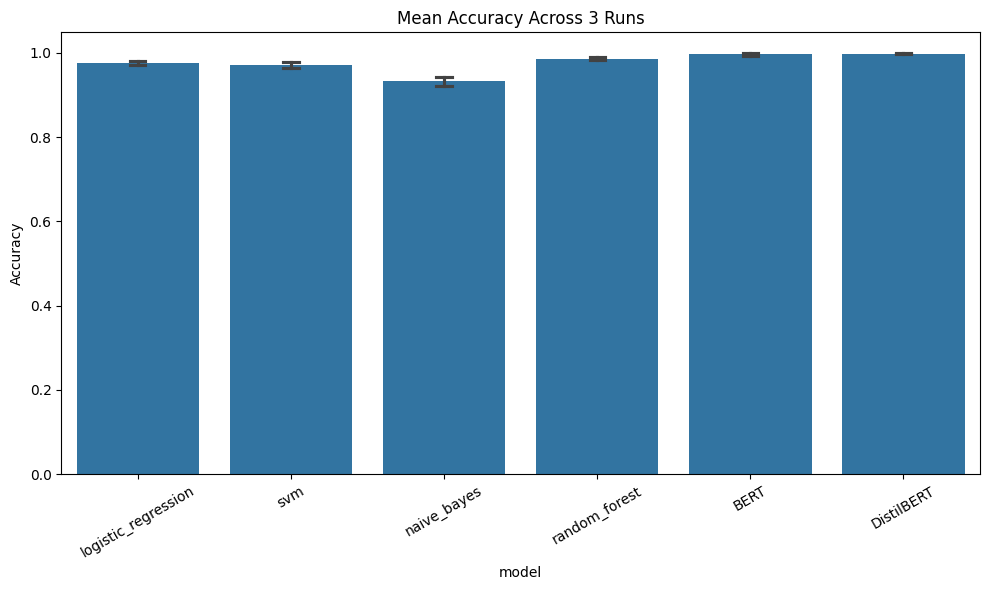

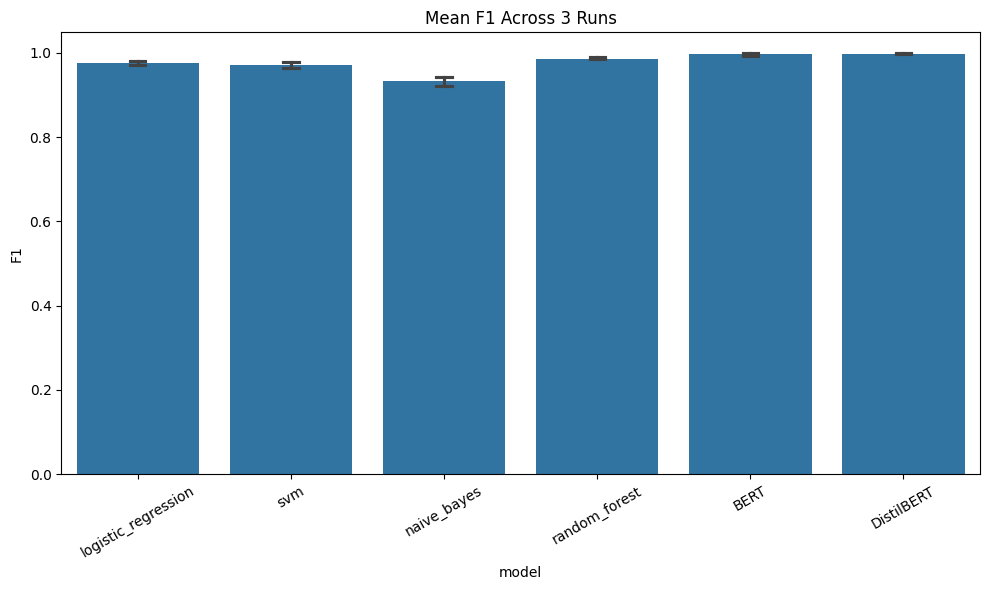

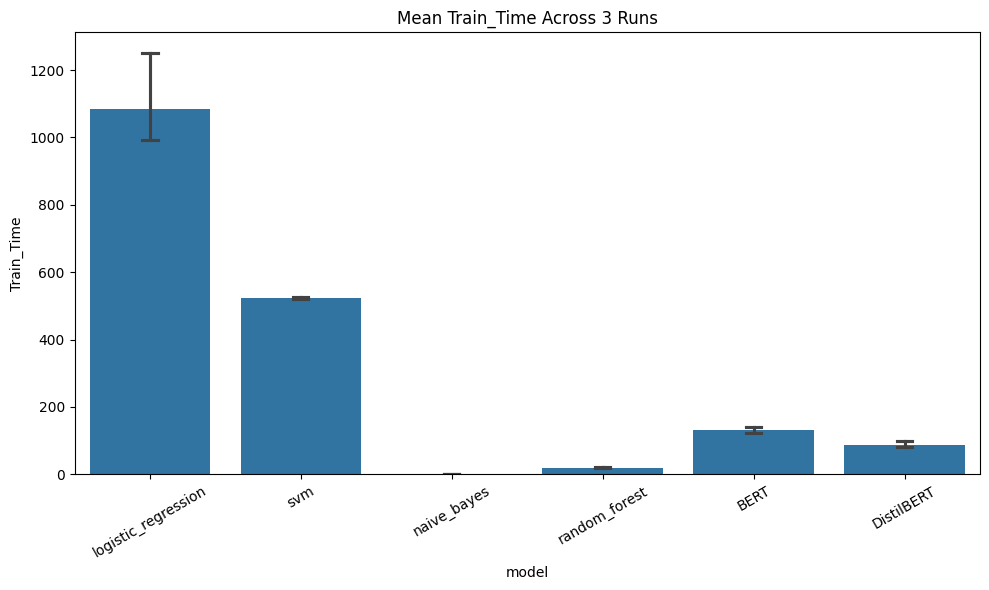

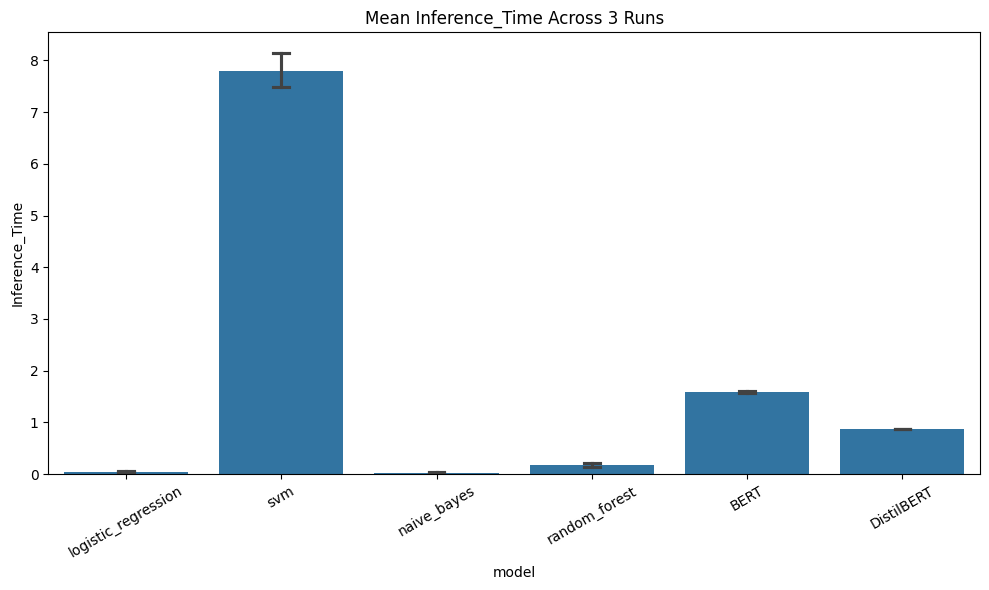


 ETHICAL BIAS ANALYSIS:
  Left-wing accuracy: 1.00, FPR: 0.00
  Right-wing accuracy: 1.00, FPR: 0.00


 Misclassified examples saved.


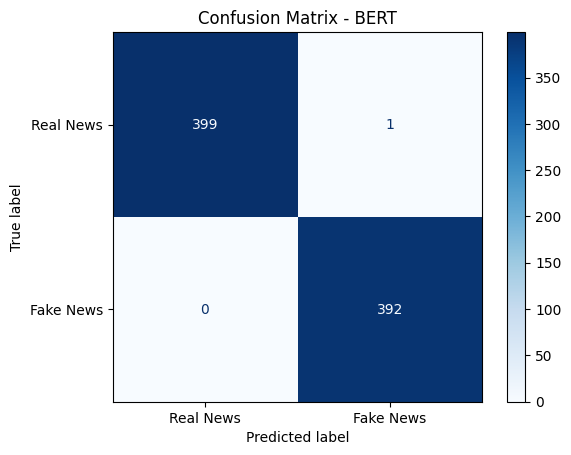

 Confusion matrix plot saved and displayed.


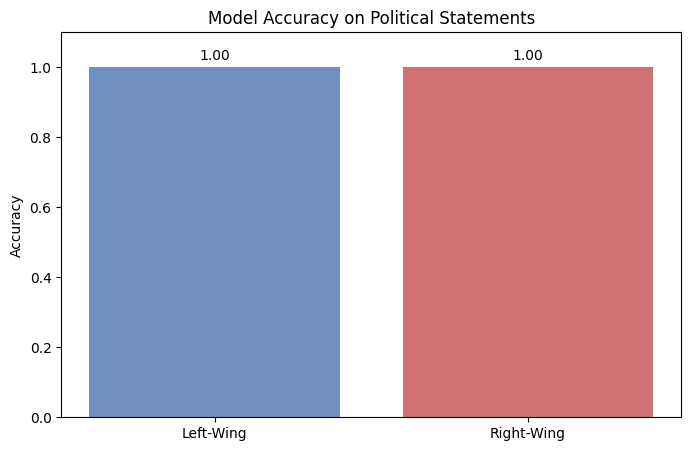

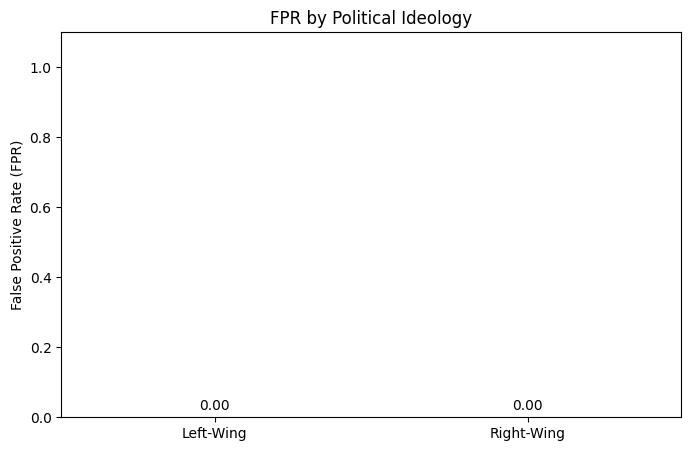

 Bias analysis plots saved and displayed.
 Capstone project completed successfully! All results saved to /results/


In [9]:
def main():
    """
    Main execution function that runs the complete experiment:
    1. Loads and preprocesses data
    2. Extracts features
    3. Trains traditional and transformer models
    4. Evaluates all models
    5. Performs bias and error analysis
    6. Generates results and visualizations
    """
    all_results = []

    for seed in SEEDS:
        print(f"\n{'='*50}")
        print(f" Running experiment with seed={seed}")
        print(f"{'='*50}")

        # Data loading and preprocessing
        dl = DataLoader(seed=seed)
        df = dl.load_data()
        if df is None or len(df) == 0:
            logger.error(f"Skipping seed {seed} due to data load failure.")
            continue

        X = df['text']
        y = df['label']
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=seed, stratify=y
        )

        # Feature extraction
        fe = FeatureExtractor()
        X_train_trad = fe.extract_traditional_features(X_train, fit=True)
        X_test_trad = fe.extract_traditional_features(X_test, fit=False)

        # Traditional model training
        tm = TraditionalModels(seed=seed)
        trad_results = tm.train(X_train_trad, y_train)
        evaluator = ModelEvaluator()
        run_metrics = {}

        # Traditional model evaluation
        for name, res in trad_results.items():
            if res['model'] is not None:
                m = evaluator.evaluate(res['model'], X_test_trad, y_test, model_type=name)
                m['train_time'] = res['train_time']
                run_metrics[name] = m
                joblib.dump(res['model'], f'results/models/{name}_model_{seed}.pkl')
            else:
                logger.warning(f"Model {name} failed to train for seed {seed}.")

        # BERT training and evaluation
        try:
            train_bert = fe.prepare_bert_data(X_train, y_train)
            val_bert = train_bert.train_test_split(test_size=0.1, seed=seed)['test']
            test_bert = fe.prepare_bert_data(X_test)
            bert = BERTClassifier("bert-base-uncased", AutoTokenizer, AutoModelForSequenceClassification)
            bert_res = bert.train(train_bert, val_bert, seed=seed)
            bert_metrics = evaluator.evaluate(bert_res['model'], test_bert, y_test, model_type='bert')
            bert_metrics['train_time'] = bert_res.get('train_time', 0)
            run_metrics['BERT'] = bert_metrics
        except Exception as e:
            logger.error(f"BERT training failed for seed {seed}: {e}")
            bert_metrics = {m: 0 for m in evaluator.metrics + ['train_time']}
            run_metrics['BERT'] = bert_metrics

        # DistilBERT training and evaluation
        try:
            train_distil = fe.prepare_distilbert_data(X_train, y_train)
            val_distil = train_distil.train_test_split(test_size=0.1, seed=seed)['test']
            test_distil = fe.prepare_distilbert_data(X_test)
            distilbert = BERTClassifier("distilbert-base-uncased", DistilBertTokenizer, DistilBertForSequenceClassification)
            distil_res = distilbert.train(train_distil, val_distil, seed=seed)
            distil_metrics = evaluator.evaluate(distil_res['model'], test_distil, y_test, model_type='distilbert')
            distil_metrics['train_time'] = distil_res.get('train_time', 0)
            run_metrics['DistilBERT'] = distil_metrics
        except Exception as e:
            logger.error(f"DistilBERT training failed for seed {seed}: {e}")
            distil_metrics = {m: 0 for m in evaluator.metrics + ['train_time']}
            run_metrics['DistilBERT'] = distil_metrics

        # Save all results
        for model_name, metrics in run_metrics.items():
            row = {'seed': seed, 'model': model_name}
            row.update(metrics)
            all_results.append(row)

    # Final Summary
    if not all_results:
        logger.error("No results were generated. Exiting.")
        return

    results_df = pd.DataFrame(all_results)
    if 'model' not in results_df.columns:
        logger.error("No valid results to summarize.")
        return

    summary = results_df.groupby('model')[['accuracy', 'f1', 'train_time', 'inference_time']].agg(['mean', 'std'])
    summary.columns = ['_'.join(col).strip() for col in summary.columns]
    summary = summary.round(4)
    summary.to_csv('results/final_summary.csv')
    print("\n FINAL RESULTS (mean ± std):")
    print(summary)

    # Generate plots (with display)
    metrics_to_plot = ['accuracy', 'f1', 'train_time', 'inference_time']
    for metric in metrics_to_plot:
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(data=results_df, x='model', y=metric, estimator=np.mean, errorbar=('ci', 95), capsize=0.1)
        plt.title(f'Mean {metric.title()} Across {N_RUNS} Runs')
        plt.ylabel(metric.title())
        plt.xticks(rotation=30)
        plt.tight_layout()
        plt.savefig(f'results/plots/{metric}_comparison.png', dpi=200, bbox_inches='tight')
        plt.show()
        plt.close()

    # Bias & Error Analysis
    if 'bert_res' in locals() and bert_res.get('model'):
        evaluate_ethical_bias(bert_res['model'], X_test, y_test, 'bert')
        log_misclassifications(bert_res['model'], test_bert, y_test, 'bert', X_test_raw=X_test)
    else:
        logger.warning("Skipping bias and error analysis: BERT model not available.")

    # Additional Plots (Confusion Matrix & Bias Charts)
    try:
        os.makedirs('results/plots', exist_ok=True)

        # Plot 5: Confusion Matrix
        if 'bert_res' in locals() and bert_res.get('model') is not None:
            from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
            pred = bert_res['model'].predict(test_bert)
            y_pred = pred.predictions.argmax(-1)
            cm = confusion_matrix(y_test, y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real News', 'Fake News'])
            disp.plot(cmap='Blues', values_format='d')
            plt.title('Confusion Matrix - BERT')
            plt.savefig('results/plots/cm_bert.png', bbox_inches='tight')
            plt.show()
            plt.close()
            print(" Confusion matrix plot saved and displayed.")

        # Plot 6: Bias Analysis Charts
        bias_file = 'results/ethical_bias_analysis.csv'
        if os.path.exists(bias_file):
            bias_df = pd.read_csv(bias_file)
            left_mask = bias_df['ideology'] == 'left'
            right_mask = bias_df['ideology'] == 'right'

            left_acc = accuracy_score(bias_df.loc[left_mask, 'label'], bias_df.loc[left_mask, 'pred'])
            right_acc = accuracy_score(bias_df.loc[right_mask, 'label'], bias_df.loc[right_mask, 'pred'])
            fpr_left = sum((bias_df.loc[left_mask, 'pred'] == 1) & (bias_df.loc[left_mask, 'label'] == 0)) / len(bias_df[left_mask])
            fpr_right = sum((bias_df.loc[right_mask, 'pred'] == 1) & (bias_df.loc[right_mask, 'label'] == 0)) / len(bias_df[right_mask])

            # Accuracy chart
            plt.figure(figsize=(8, 5))
            plt.bar(['Left-Wing', 'Right-Wing'], [left_acc, right_acc], color=['#4C72B0', '#C44E52'], alpha=0.8)
            plt.ylabel('Accuracy')
            plt.title('Model Accuracy on Political Statements')
            plt.ylim(0, 1.1)
            for i, v in enumerate([left_acc, right_acc]):
                plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
            plt.savefig('results/plots/bias_accuracy.png', bbox_inches='tight')
            plt.show()
            plt.close()

            # FPR chart
            plt.figure(figsize=(8, 5))
            plt.bar(['Left-Wing', 'Right-Wing'], [fpr_left, fpr_right], color=['#4C72B0', '#C44E52'], alpha=0.8)
            plt.ylabel('False Positive Rate (FPR)')
            plt.title('FPR by Political Ideology')
            plt.ylim(0, 1.1)
            for i, v in enumerate([fpr_left, fpr_right]):
                plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
            plt.savefig('results/plots/bias_fpr.png', bbox_inches='tight')
            plt.show()
            plt.close()

            print(" Bias analysis plots saved and displayed.")
    except Exception as e:
        logger.warning(f"Plot generation failed: {e}")

    print(" Capstone project completed successfully! All results saved to /results/")

if __name__ == "__main__":
    main()